<a href="https://colab.research.google.com/github/vaibhav2903/deepfakeDetection/blob/main/SEDC_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
from skimage.segmentation import slic
from tensorflow.keras.models import load_model
import keras
from google.colab import drive

# Load your deepfake detection model
drive.mount('/content/drive/')
model = keras.models.load_model('/content/drive/MyDrive/my_cnn_model1.h5')

Mounted at /content/drive/


In [ ]:
import numpy as np
file_path_X = '/content/drive/MyDrive/X_data.npy'
np_data_X = np.load(file_path_X)
file_path_Y = '/content/drive/MyDrive/Y_data.npy'
np_data_Y = np.load(file_path_Y)

In [ ]:
features_test = np_data_X[7001:13000]
labels_test = np_data_Y[7001:13000]

In [ ]:
predictions_prob = model.predict(features_test)
predictions = (predictions_prob > 0.5).astype("int32")

188/188 [==============================] - 2s 8ms/step


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 27 13:58:26 2020

@author: TVermeire
"""

def sedc(image, classifier, segments, mode):

    import numpy as np
    import cv2

    result = classifier.predict(image[np.newaxis,...])
    c = np.argmax(result)
    p = result[0,c]
    R = [] #list of explanations
    I = [] #corresponding perturbed images
    C = [] #corresponding new classes
    P = [] #corresponding scores for original class
    sets_to_expand_on = []
    P_sets_to_expand_on = np.array([])


    if mode == 'mean':
        perturbed_image = np.zeros((224,224,3))
        perturbed_image[:,:,0] = np.mean(image[:,:,0])
        perturbed_image[:,:,1] = np.mean(image[:,:,1])
        perturbed_image[:,:,2] = np.mean(image[:,:,2])
    elif mode == 'blur':
        perturbed_image = cv2.GaussianBlur(image, (31,31), 0)
    elif mode == 'random':
        perturbed_image = np.random.random((224,224,3))
    elif mode == 'inpaint':
        perturbed_image = np.zeros((224,224,3))
        for j in np.unique(segments):
            image_absolute = (image*255).astype('uint8')
            mask = np.full([image_absolute.shape[0],image_absolute.shape[1]],0)
            mask[segments == j] = 255
            mask = mask.astype('uint8')
            image_segment_inpainted = cv2.inpaint(image_absolute, mask, 3, cv2.INPAINT_NS)
            perturbed_image[segments == j] = image_segment_inpainted[segments == j]/255.0

    perturbed_image

    for j in np.unique(segments):
        test_image = image.copy()
        test_image[segments == j] = perturbed_image[segments == j]

        result = classifier.predict(test_image[np.newaxis,...])
        c_new = np.argmax(result)
        p_new = result[0,c]
        print(j)
        if c_new != c:
            R.append([j])
            I.append(test_image)
            C.append(c_new)
            P.append(p_new)

        else:
            sets_to_expand_on.append([j])
            P_sets_to_expand_on = np.append(P_sets_to_expand_on,p-p_new)


    while len(R) == 0:
        print(R)
        combo = np.argmax(P_sets_to_expand_on)
        combo_set = []
        for j in np.unique(segments):
            if j not in sets_to_expand_on[combo]:
                combo_set.append(np.append(sets_to_expand_on[combo],j))

        # Make sure to not go back to previous node
        del sets_to_expand_on[combo]
        P_sets_to_expand_on = np.delete(P_sets_to_expand_on,combo)
        print(combo_set)
        for cs in combo_set:

            test_image = image.copy()
            for k in cs:
                test_image[segments == k] = perturbed_image[segments == k]

            result = classifier.predict(test_image[np.newaxis,...])
            c_new = np.argmax(result)
            p_new = result[0,c]

            if c_new != c:
                R.append(cs)
                I.append(test_image)
                C.append(c_new)
                P.append(p_new)

            else:
                sets_to_expand_on.append(cs)
                P_sets_to_expand_on = np.append(P_sets_to_expand_on,p-p_new)

    # Select best explanation: highest score reduction

    best_explanation = np.argmax(p - P)
    segments_in_explanation = R[best_explanation]
    explanation = np.full([image.shape[0],image.shape[1],image.shape[2]],0/255.0)
    for i in R[best_explanation]:
        explanation[segments == i] = image[segments == i]
    perturbation = I[best_explanation]
    new_class = C[best_explanation]

    return explanation, segments_in_explanation, perturbation, new_class


In [ ]:
segments = quickshift(features_test[4039], kernel_size=4, max_dist=200, ratio=0.2)
explanation, segments_in_explanation, perturbation, new_class = sedc(features_test[4039], model, segments, 'mean')

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step
[]
[array([16,  3, 12, 22, 17, 30, 33, 19,  1,  2, 26,  0]), array([16,  3, 12, 22, 17, 30, 33, 19,  1,  2, 26,  4]), array([16,  3, 12, 22, 17, 30, 33, 19,  1,  2, 26,  5]), array([16,  3, 12, 22, 17, 30, 33, 19,  1,  2, 26,  6]), array([16,  3, 12, 22, 17, 30, 33, 19,  1,  2, 26,  7]), array([16,  3, 12, 22, 17, 30, 33, 19,  1,  2, 26,  8]), array([16,  3, 12, 22, 17, 30, 33, 19,  1,  2, 26,  9]), array([16,  3, 12, 22, 17, 30, 33, 19,  1,  2, 26, 10]), array([16,  3, 12, 22, 17, 30, 33, 19,  1,  2, 26, 11]), array([16,  3, 12, 22, 17, 30, 33, 19,  1,  2, 26, 13]), array([16,  3, 12, 22, 17, 30, 33, 19,  1,  2, 26, 14]), array([16,  3, 12, 22, 17, 30, 33, 19,  1,  2, 26, 15]), array([16,  3, 12, 22, 17, 30, 33, 19,  1,  2, 26, 18]), array([16,  3, 12, 22, 17, 30, 33, 19,  1,  2, 26, 20]), array([16,  3, 12, 22, 17, 30, 33, 19,  1,  2, 26, 21]), array([16,  3, 12, 22, 17, 30, 33, 19,

KeyboardInterrupt: 

In [ ]:
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed, mark_boundaries

array([[[181, 181, 133],
        [179, 181, 133],
        [177, 181, 132],
        ...,
        [190, 197, 194],
        [190, 197, 194],
        [190, 197, 194]],

       [[180, 180, 132],
        [178, 180, 132],
        [177, 179, 132],
        ...,
        [190, 197, 194],
        [190, 197, 194],
        [189, 196, 193]],

       [[181, 181, 133],
        [178, 179, 132],
        [176, 178, 132],
        ...,
        [189, 196, 193],
        [189, 196, 193],
        [189, 196, 193]],

       ...,

       [[ 69,  92, 114],
        [ 62,  85, 106],
        [ 60,  84, 104],
        ...,
        [ 50,  72,  97],
        [ 57,  78, 104],
        [ 79, 100, 127]],

       [[ 70,  93, 116],
        [ 62,  86, 108],
        [ 59,  83, 104],
        ...,
        [ 52,  73,  99],
        [ 58,  79, 105],
        [ 71,  92, 119]],

       [[ 70,  94, 118],
        [ 62,  86, 108],
        [ 58,  82, 104],
        ...,
        [ 47,  66,  93],
        [ 49,  69,  96],
        [ 50,  71,  98]]], dtype=uint8)
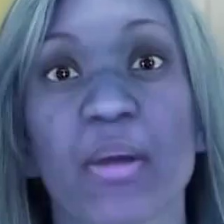

In [ ]:
features_test[4039]

In [ ]:
labels_test[4039]

1

In [ ]:
misclassified_output1 = []

for i in range(len(labels_test)):
  if labels_test[i]!=predictions[i][0] and labels_test[i]==1 and predictions[i][0]==0:
      misclassified_output1.append(i)

In [ ]:
misclassified_output1

[2747,
 2749,
 2750,
 2752,
 2754,
 2757,
 2761,
 2762,
 2764,
 2766,
 2768,
 2770,
 2772,
 2774,
 2776,
 2778,
 2789,
 2790,
 2791,
 2792,
 2794,
 2795,
 2796,
 2797,
 2798,
 2799,
 2800,
 2801,
 2802,
 2803,
 2804,
 2805,
 2826,
 2827,
 2829,
 2830,
 2831,
 2832,
 2833,
 2834,
 2835,
 2837,
 2900,
 2905,
 2907,
 2920,
 2921,
 2924,
 2926,
 2952,
 2973,
 2975,
 2977,
 2979,
 2982,
 2985,
 2987,
 2989,
 2994,
 2999,
 3000,
 3002,
 3003,
 3004,
 3005,
 3006,
 3007,
 3050,
 3051,
 3053,
 3055,
 3057,
 3059,
 3061,
 3073,
 3075,
 3076,
 3077,
 3080,
 3089,
 3090,
 3092,
 3093,
 3094,
 3095,
 3096,
 3117,
 3119,
 3121,
 3123,
 3126,
 3128,
 3130,
 3131,
 3132,
 3165,
 3167,
 3169,
 3171,
 3173,
 3192,
 3193,
 3199,
 3219,
 3220,
 3221,
 3222,
 3223,
 3224,
 3225,
 3226,
 3227,
 3238,
 3240,
 3241,
 3242,
 3244,
 3245,
 3246,
 3248,
 3250,
 3254,
 3268,
 3349,
 3450,
 3452,
 3454,
 3456,
 3460,
 3488,
 3489,
 3490,
 3494,
 3496,
 3513,
 3527,
 3566,
 3568,
 3570,
 3572,
 3579,
 3665,
 3672,

array([[[ 20,   9,  12],
        [ 20,   9,  12],
        [ 20,   9,  12],
        ...,
        [110,  75,  62],
        [112,  74,  62],
        [111,  73,  61]],

       [[ 20,   9,  12],
        [ 20,   9,  12],
        [ 20,   9,  12],
        ...,
        [111,  76,  63],
        [113,  75,  63],
        [113,  75,  63]],

       [[ 22,   8,  12],
        [ 22,   8,  12],
        [ 19,   8,  11],
        ...,
        [114,  77,  63],
        [117,  78,  64],
        [117,  78,  64]],

       ...,

       [[  1,   0,  32],
        [  1,   0,  32],
        [  1,   0,  32],
        ...,
        [  0,   1,  32],
        [  0,   0,  34],
        [  1,   0,  34]],

       [[  1,   0,  32],
        [  1,   0,  32],
        [  1,   0,  32],
        ...,
        [  0,   0,  34],
        [  3,   0,  34],
        [  5,   0,  34]],

       [[  1,   0,  32],
        [  1,   0,  32],
        [  1,   0,  32],
        ...,
        [  1,   0,  34],
        [  5,   0,  34],
        [  6,   0,  34]]], dtype=uint8)
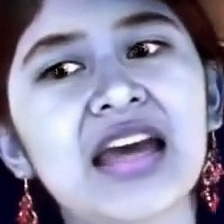

In [ ]:
features_test[3946]

Text(0.5, 1.0, 'Segmented Image')

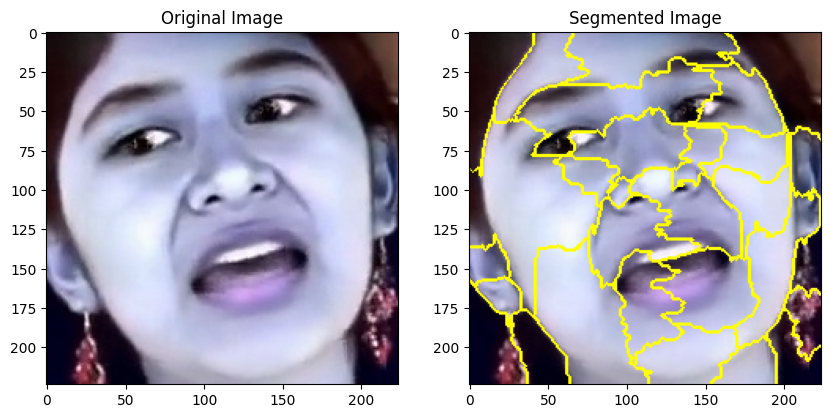

In [ ]:
import matplotlib.pyplot as plt
segments = quickshift(features_test[3946], kernel_size=4, max_dist=200, ratio=0.2)
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(features_test[3946])
plt.title('Original Image')

# Segmented image
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(features_test[3946], segments))
plt.title('Segmented Image')